In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

from tqdm import tqdm

from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Input, Dropout, Conv2DTranspose, Add
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
from keras import backend as K

from sklearn.model_selection import train_test_split

In [38]:
# Load Data into corresponding array

def load_data(path: str):
  dir = sorted(os.listdir(path))
  data = []
  gt = []

  for patient in tqdm(dir):
    current_path = path + patient + '/'
    data_list = sorted(os.listdir(current_path))

    tmp_img = sitk.ReadImage(current_path + data_list[0])
    flair = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[1])
    seg = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[2])
    t1 = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[3])
    t1ce = sitk.GetArrayFromImage(tmp_img)

    tmp_img = sitk.ReadImage(current_path + data_list[4])
    t2 = sitk.GetArrayFromImage(tmp_img)

    data.append([flair, t1, t1ce, t2])
    gt.append(seg)

  data = np.asarray(data, dtype = np.float32)
  gt = np.asarray(gt, dtype = np.uint8)
  return data, gt


data, gt = load_data("Dataset/")



100%|██████████| 12/12 [00:01<00:00,  6.42it/s]


In [39]:
# Reorganise the data
data = np.transpose(data, (0, 2, 3, 4, 1))

In [40]:
# Filter the unusuable slices out of the images
data = data[:, 30:120, 30:222, 30:222, :].reshape([-1, 192, 192, 4])   

gt = gt[:, 30:120, 30:222, 30:222].reshape([-1, 192, 192, 1])
gt[np.where(gt == 4)] = 3

In [41]:
# Just as in the ISEG challenge we create a training, validation and test arrays
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(data, gt, test_size = 0.2, random_state = 69)
XTRAIN, XVAL, YTRAIN, YVAL = train_test_split(XTRAIN, YTRAIN, test_size = 0.25, random_state = 69)

In [42]:
# We label each image
YTRAIN = to_categorical(YTRAIN)
YVAL = to_categorical(YVAL)

In [43]:
# We normalize the images for pre-processing
XTRAIN = (XTRAIN - np.mean(XTRAIN)) / np.max(XTRAIN)
XTEST = (XTEST - np.mean(XTEST)) / np.max(XTEST)
XVAL = (XVAL - np.mean(XVAL)) / np.max(XVAL)

In [44]:
# Functions to get the dice coeficients
def dice_coef(y_true, y_pred, epsilon = 1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    return (2. * intersection) / (K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis = -1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Encoding - Decoding Enhanced Neural Network

## Explanation
- Data preprocessing: The first step is to prepare the medical imaging data for training the neural network. This involves pre-processing steps such as normalization, resizing, and intensity normalization to ensure consistency and optimize the data for training.

- Encoding: The encoding component is responsible for capturing and representing the salient features of the input medical images. It typically consists of multiple convolutional layers that perform feature extraction. These layers gradually reduce the spatial dimensions of the input image while increasing the number of channels or feature maps. This process helps the network to learn hierarchical representations of the input images.

- Bridge: After the encoding layers, there is often a bridge component that connects the encoding and decoding parts of the network. It serves as a bottleneck layer and further compresses the extracted features.

- Decoding: The decoding component takes the compressed features from the bridge and gradually upscales and expands them to generate a segmentation map that matches the original input image's dimensions. The decoding layers typically consist of transposed convolutions or upsampling operations, followed by convolutional layers. These layers aim to recover the spatial information lost during encoding and generate a detailed segmentation map.

- Output: The final output of the network is a segmentation map that assigns a label or probability to each pixel or voxel in the input image, indicating whether it belongs to a tumor or background. The network is trained using annotated data where the ground truth segmentations are available. During training, the network's predicted segmentation map is compared to the ground truth, and the model's parameters are adjusted through a process called backpropagation and gradient descent to minimize the segmentation error.

Enhancement with encoding and decoding: The encoding and decoding components enhance the brain tumor segmentation network in several ways. The encoding layers allow the network to capture meaningful features from the input images, while the decoding layers help reconstruct the detailed segmentation map.

By training the network on a large dataset of annotated brain MRI scans, this architecture can learn to segment brain tumors accurately and efficiently, aiding medical professionals in diagnosis and treatment decisions

In [45]:
# For detailed explanation,
# https://scholar.google.com/scholar_url?url = https://www.mdpi.com/2075-4418/11/2/169/pdf&hl = en&sa = X&ei = -einZOmRJ92Sy9YP2fyhwAg&scisig = ABFrs3yeUhayVRfJMdM5VFI6lb78&oi = scholarr

# encoder

inputs = Input(shape = (192, 192, 4), name = 'input')

block0_conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'block0_conv1') (inputs)
block0_norm1 = BatchNormalization(name = 'block0_batch_norm1') (block0_conv1)
block0_conv2 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'block0_conv2') (block0_norm1)
block0_norm2 = BatchNormalization(name = 'block0_batch_norm2') (block0_conv2)
block0_pool = MaxPooling2D(name = 'block0_pool') (block0_norm2)

block1_conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'block1_conv1') (block0_pool)
block1_norm1 = BatchNormalization(name = 'block1_batch_norm1') (block1_conv1)
block1_conv2 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'block1_conv2') (block1_norm1)
block1_norm2 = BatchNormalization(name = 'block1_batch_norm2') (block1_conv2)
block1_pool = MaxPooling2D(name = 'block1_pool') (block1_norm2)

block2_conv1 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'block2_conv1') (block1_pool)
block2_norm1 = BatchNormalization(name = 'block2_batch_norm1') (block2_conv1)
block2_conv2 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'block2_conv2') (block2_norm1)
block2_norm2 = BatchNormalization(name = 'block2_batch_norm2') (block2_conv2)
block2_pool = MaxPooling2D(name = 'block2_pool') (block2_norm2)

encoder_dropout_1 = Dropout(0.2, name = 'encoder_dropout_1') (block2_pool)

block3_conv1 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'block3_conv1') (encoder_dropout_1)
block3_norm1 = BatchNormalization(name = 'block3_batch_norm1') (block3_conv1)
block3_conv2 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'block3_conv2') (block3_norm1)
block3_norm2 = BatchNormalization(name = 'block3_batch_norm2') (block3_conv2)
block3_pool = MaxPooling2D(name = 'block3_pool') (block3_norm2)

block4_conv1 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'block4_conv1') (block3_pool)
block4_norm1 = BatchNormalization(name = 'block4_batch_norm1') (block4_conv1)
block4_conv2 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'block4_conv2') (block4_norm1)
block4_norm2 = BatchNormalization(name = 'block4_batch_norm2') (block4_conv2)
block4_pool = MaxPooling2D(name = 'block4_pool') (block4_norm2)

block5_conv1 = Conv2D(1024, 3, padding = 'same', activation = 'relu', name = 'block5_conv1') (block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool1') (block5_conv1)
merged_block1 = Add() ([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'decod_block1_conv1') (merged_block1)

up_pool2 = Conv2DTranspose(256, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool2') (decod_block1_conv1)
merged_block2 = Add() ([block3_norm1, block3_norm2, up_pool2])
decod_block2_conv1 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'decod_block2_conv1') (merged_block2)

decoder_dropout_1 = Dropout(0.2, name = 'decoder_dropout_1') (decod_block2_conv1)

up_pool3 = Conv2DTranspose(128, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool3') (decoder_dropout_1)
merged_block3 = Add() ([block2_norm1, block2_norm2 , up_pool3])
decod_block3_conv1 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'decod_block3_conv1') (merged_block3)

up_pool4 = Conv2DTranspose(64, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool4') (decod_block3_conv1)
merged_block4 = Add() ([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'decod_block4_conv1') (merged_block4)

up_pool5 = Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool5') (decod_block4_conv1)
merged_block5 = Add() ([block0_norm1, block0_norm2 , up_pool5])
decod_block5_conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'decod_block5_conv1') (merged_block5)

#encoder
block6_conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'block6_conv1') (decod_block5_conv1)
block6_norm1 = BatchNormalization(name = 'block6_batch_norm1') (block6_conv1)
block6_conv2 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'block6_conv2') (block6_norm1)
block6_norm2 = BatchNormalization(name = 'block6_batch_norm2') (block6_conv2)
block6_pool = MaxPooling2D(name = 'block6_pool') (block6_norm2)

block7_conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'block7_conv1') (block6_pool)
block7_norm1 = BatchNormalization(name = 'block7_batch_norm1') (block7_conv1)
block7_conv2 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'block7_conv2') (block7_norm1)
block7_norm2 = BatchNormalization(name = 'block7_batch_norm2') (block7_conv2)
block7_pool = MaxPooling2D(name = 'block7_pool') (block7_norm2)

block8_conv1 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'block8_conv1') (block7_pool)
block8_norm1 = BatchNormalization(name = 'block8_batch_norm1') (block8_conv1)
block8_conv2 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'block8_conv2') (block8_norm1)
block8_norm2 = BatchNormalization(name = 'block8_batch_norm2') (block8_conv2)
block8_pool = MaxPooling2D(name = 'block8_pool') (block8_norm2)

encoder_dropout_2 = Dropout(0.2, name = 'encoder_dropout_2') (block8_pool)

block9_conv1 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'block9_conv1') (encoder_dropout_2)
block9_norm1 = BatchNormalization(name = 'block9_batch_norm1') (block9_conv1)
block9_conv2 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'block9_conv2') (block9_norm1)
block9_norm2 = BatchNormalization(name = 'block9_batch_norm2') (block9_conv2)
block9_pool = MaxPooling2D(name = 'block9_pool') (block9_norm2)

block10_conv1 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'block10_conv1') (block9_pool)
block10_norm1 = BatchNormalization(name = 'block10_batch_norm1') (block10_conv1)
block10_conv2 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'block10_conv2') (block10_norm1)
block10_norm2 = BatchNormalization(name = 'block10_batch_norm2') (block10_conv2)
block10_pool = MaxPooling2D(name = 'block10_pool') (block10_norm2)

block11_conv1 = Conv2D(1024, 3, padding = 'same', activation = 'relu', name = 'block11_conv1') (block10_pool)

#decoder
up_pool6 = Conv2DTranspose(512, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool6') (block11_conv1)
merged_block6 = Add() ([block10_norm1, block10_norm2, up_pool6])
decod_block6_conv1 = Conv2D(512, 3, padding = 'same', activation = 'relu', name = 'decod_block6_conv1') (merged_block6)

up_pool7 = Conv2DTranspose(256, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool7') (decod_block6_conv1)
merged_block7 = Add() ([block9_norm1, block9_norm2, up_pool7])
decod_block7_conv1 = Conv2D(256, 3, padding = 'same', activation = 'relu', name = 'decod_block7_conv1') (merged_block7)

decoder_dropout_2 = Dropout(0.2, name = 'decoder_dropout_2') (decod_block7_conv1)

up_pool8 = Conv2DTranspose(128, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool8') (decoder_dropout_2)
merged_block8 = Add() ([block8_norm1, block8_norm2 , up_pool8])
decod_block8_conv1 = Conv2D(128, 3, padding = 'same', activation = 'relu', name = 'decod_block8_conv1') (merged_block8)

up_pool9 = Conv2DTranspose(64, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool9') (decod_block8_conv1)
merged_block9 = Add() ([block7_norm1, block7_norm1, up_pool9])
decod_block9_conv1 = Conv2D(64, 3, padding = 'same', activation = 'relu', name = 'decod_block9_conv1') (merged_block9)

up_pool10 = Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same', activation = 'relu', name = 'up_pool10') (decod_block9_conv1)
merged_block10 = Add() ([block6_norm1, block6_norm2 , up_pool10])
decod_block10_conv1 = Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'decod_block10_conv1') (merged_block10)

pre_output = Conv2D(32, 1, padding = 'same', activation = 'relu', name = 'pre_output') (decod_block10_conv1)

output = Conv2D(4, 1, padding = 'same', activation = 'softmax', name = 'output') (pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_batch_norm1 (BatchNorma  (None, 192, 192, 32  128        ['block0_conv1[0][0]']           
 lization)                      )                                                           

In [46]:
# Compile the model
# model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Load pre trained model
model = load_model('saved_model/my_model')


In [47]:
# Train the model and save the weights & history
# csv_logger = CSVLogger('training.log', separator = ',', append = False)
# history = model.fit(XTRAIN, YTRAIN, batch_size = 8, epochs = 10, verbose = 1, validation_data = (XVAL, YVAL), shuffle = True, callbacks = [csv_logger])
# model.save_weights('pretrained_weights/NN-Weights.h5')

In [48]:
# Save the model
# model.save('saved_model/my_model')

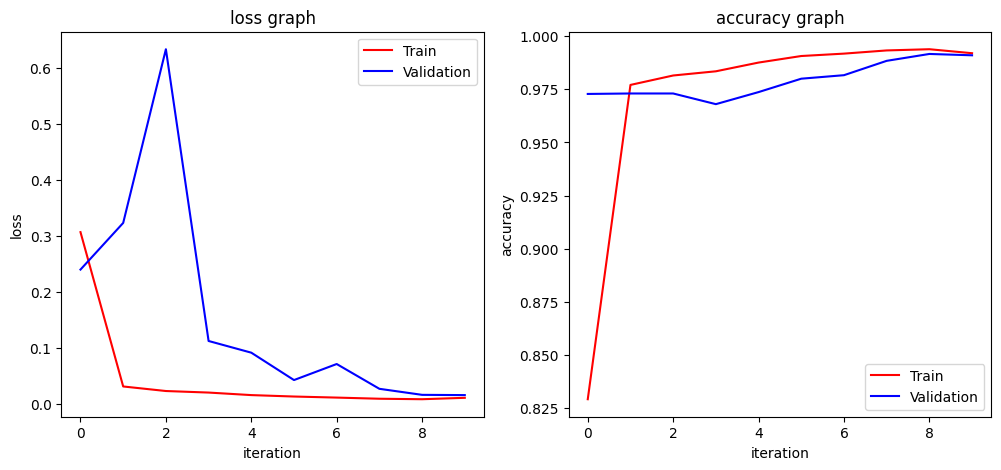

In [49]:
# Training history
training_logs = pd.read_csv('training.log', sep = ',', engine = 'python')

list_train_dice = training_logs['accuracy']
list_validation_dice = training_logs['val_accuracy']

list_train_loss = training_logs['loss']
list_validation_loss = training_logs['val_loss']

fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(list_train_loss, 'r-', label = "Train")
axes[0].plot(list_validation_loss, 'b-', label = "Validation")
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('loss')
axes[0].legend()
axes[0].title.set_text('loss graph')

axes[1].plot(list_train_dice, 'r-', label = "Train")
axes[1].plot(list_validation_dice, 'b-', label = "Validation")
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('accuracy')
axes[1].legend()
axes[1].title.set_text('accuracy graph')

fig.show()


In [51]:
# Predict and reshape
predictions = np.argmax(model.predict(XTEST), axis = -1)
predictions = predictions.reshape(-1, 192, 192, 1)

7/7 [==============================] - 18s 3s/step


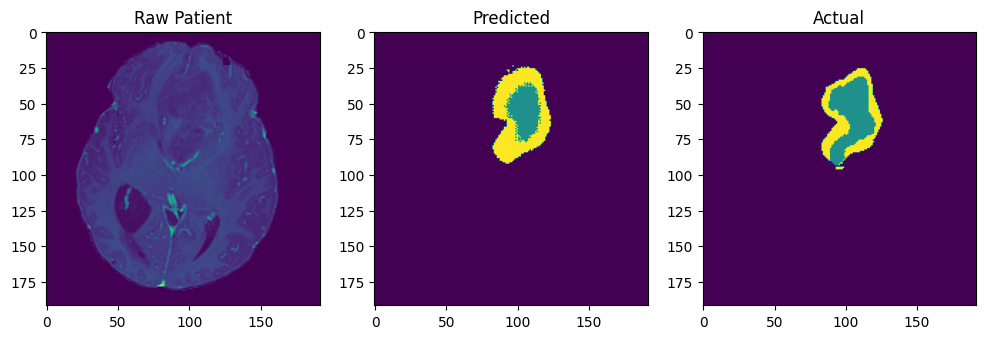

In [55]:
# Show example of the raw / predicted / actual

fig, axes = plt.subplots(1, 3, figsize = (12, 5))

patient = 1
axes[0].imshow(XTEST[patient, :, :, 2])
axes[0].set_title("Raw Patient")

axes[1].imshow(predictions[patient, :, :, 0])
axes[1].set_title("Predicted")

axes[2].imshow(YTEST[patient, :, :, 0])
axes[2].set_title("Actual")

fig.show()

# Résultats

In [56]:
# Get Overall Results
Y_test_encod = to_categorical(YTEST)
train_result = model.evaluate(XTRAIN, YTRAIN, verbose = 0)
test_result = model.evaluate(XTEST, Y_test_encod, verbose = 0)
val_result = model.evaluate(XVAL, YVAL, verbose = 0)



Le tableau ci dessous, résume les performances de notre model sur les différents sets de data 

In [57]:
pd.set_option("display.precision", 10)
pd.DataFrame([train_result,test_result,val_result], columns = ["Loss", "Dice Coefficient"], index = ["Train", "Validation", "Test"] )


,Loss,Dice Coefficient
Train,0.0176686496,0.9905176759
Validation,0.0167072881,0.9901775122
Test,0.0156547558,0.9909782410
